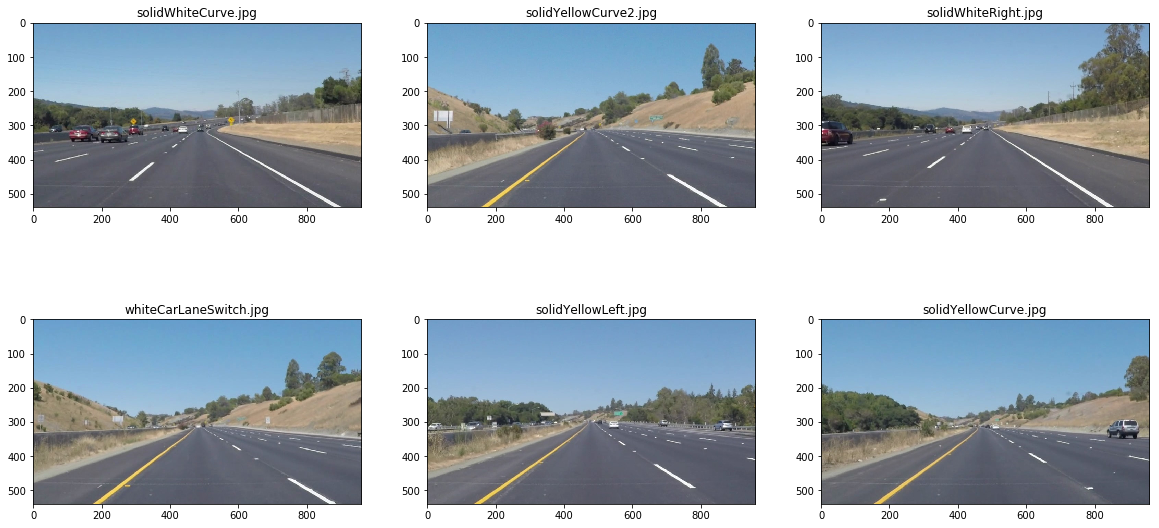

In [1]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(i, image, cmap=None):
    if i == 0:
        fig=plt.figure(figsize=(20,10))
    plt.subplot(2, 3, i+1)
    plt.title(image_list[i])
    plt.imshow(image, cmap=cmap)

image_dir = "test_images/"
image_list = os.listdir(image_dir)

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    show_image(i, image)

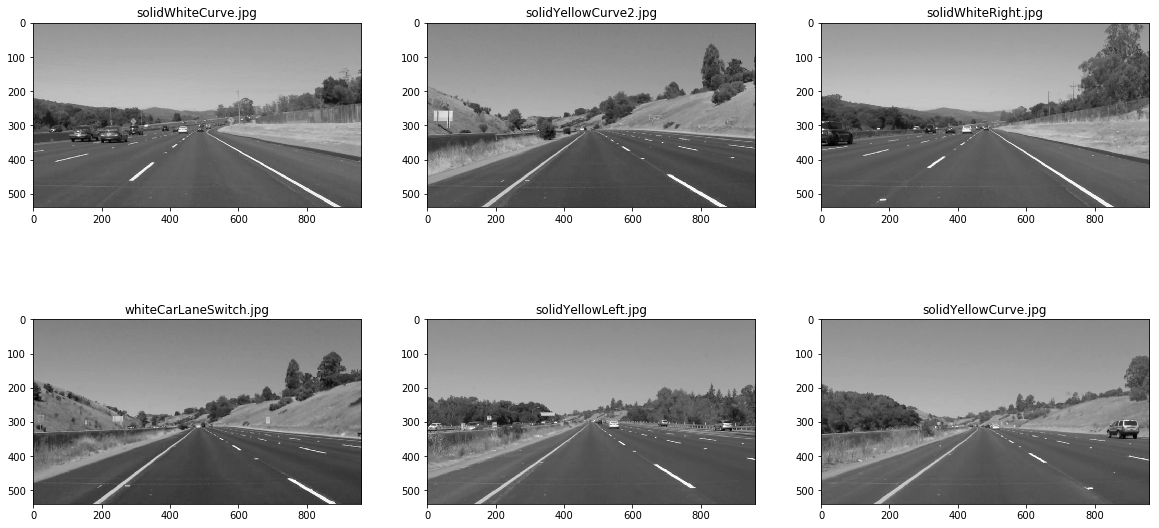

In [2]:
import cv2  #bringing in OpenCV libraries

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    show_image(i, image_gray, cmap='gray')

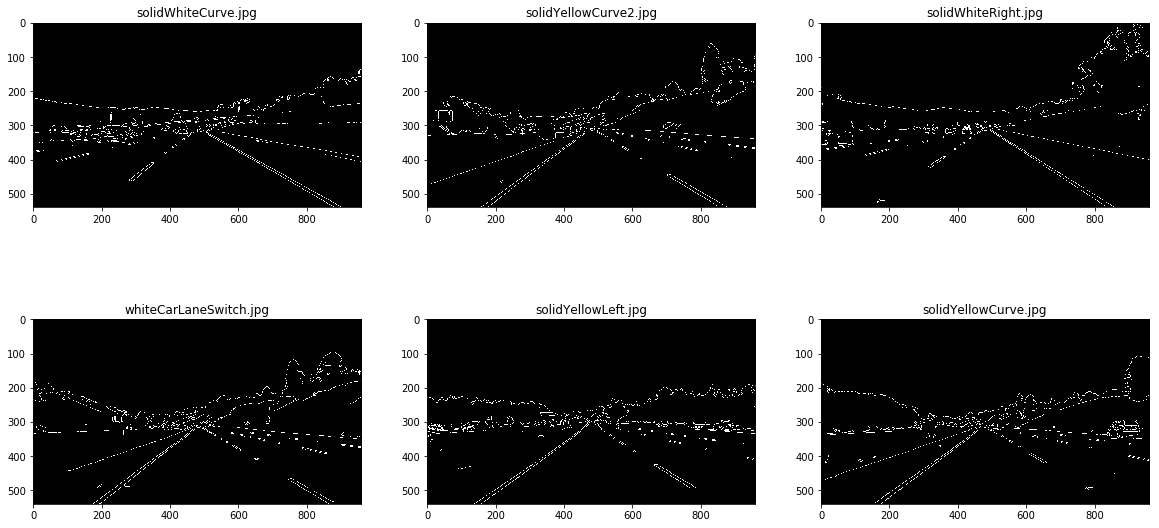

In [3]:
import numpy as np

def canny_edge(image):
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(image,(kernel_size, kernel_size), 0)

    # Define parameters for Canny and run it
    # NOTE: if you try running this code you might want to change these!
    low_threshold = 50
    high_threshold = 150
    masked_edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    return masked_edges

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    image_canny = canny_edge(image_gray)
    show_image(i, image_canny, cmap='Greys_r')

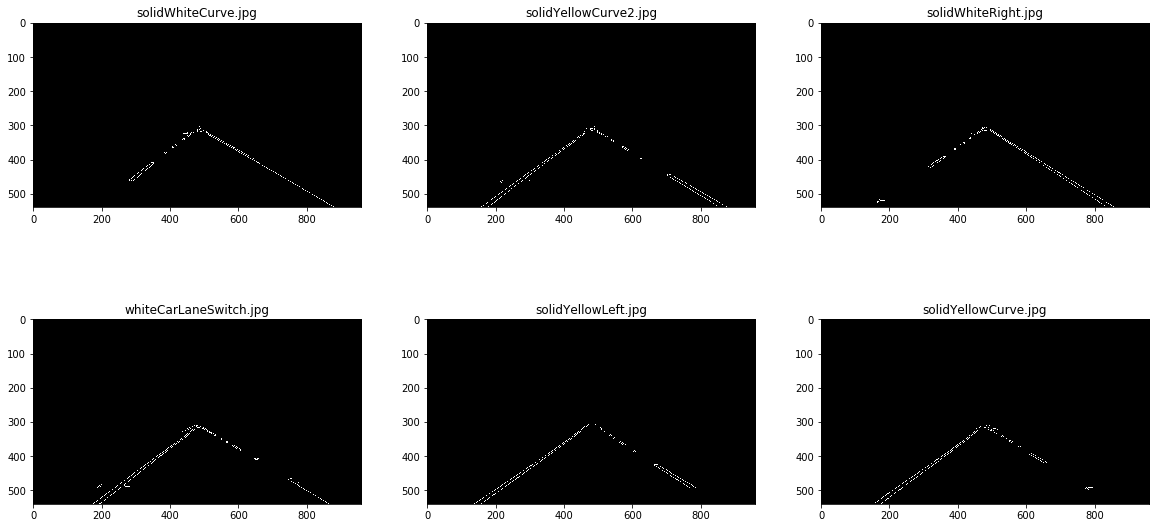

In [4]:
def make_mask(image):
    ysize = image.shape[0]
    xsize = image.shape[1]

    left_bottom = [xsize/12, ysize]
    right_bottom = [xsize-xsize/12, ysize]
    apex = [xsize/2, ysize/9*5]

    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))

#     plt.imshow(region_thresholds)
    return region_thresholds


for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_canny = canny_edge(image_gray)
    
    mask_area = make_mask(image)
    image_canny_mask = image_canny * mask_area
    
    show_image(i, image_canny_mask, cmap='Greys_r')

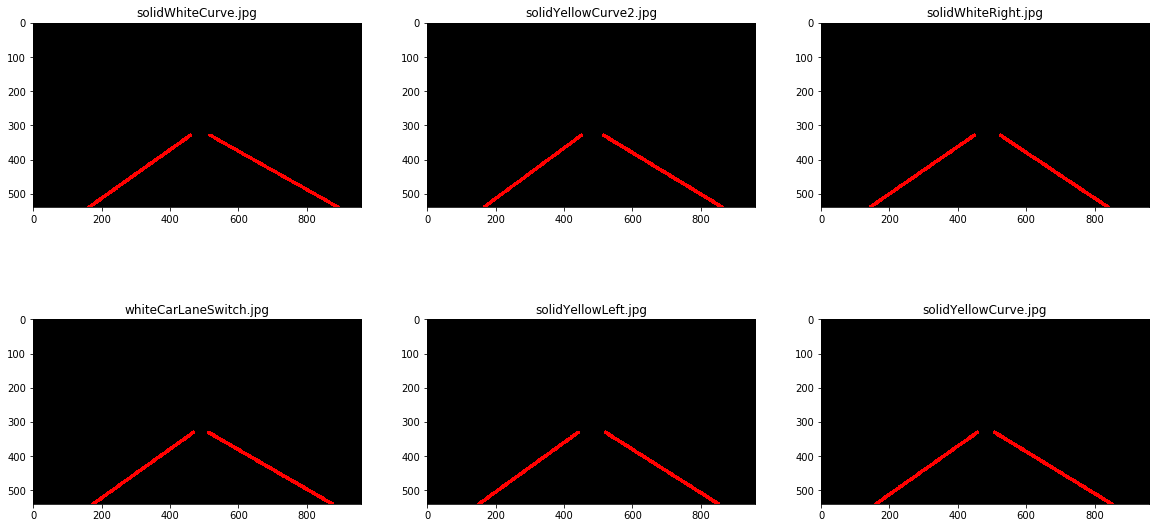

In [5]:
import math
from numba.decorators import jit

@jit
def lines_totalization(line_image, lines):
    if lines.shape[0] <= 1:
        print('none')
        return line_image
    
    ysize = line_image.shape[0]
    xsize = line_image.shape[1]
    
    lines = np.delete(lines, 0, 0)
    slope = lines[:, 4].mean()
    center_x = lines[:, 5].mean()
    center_y = lines[:, 6].mean()
    segment = center_y - slope*center_x
    
    if slope != 0:
        bottom_y = ysize
        bottom_x = int((bottom_y - segment) / slope)
        top_y = int(ysize/9*5.5)
        top_x = int((top_y - segment) / slope)

        # print(lines.shape, lines.dtype, slope, center_x, center_y, segment)
        # print(lines)

        cv2.line(line_image,(bottom_x,bottom_y),(top_x,top_y),(255,0,0),10)
    
    return line_image

@jit
def hough_transform(raw_image, masked_image, \
                    rho=2, theta=np.pi/180, threshold=15, min_line_length=12, max_line_gap=2,\
                    slope_th_min=0.5, slope_th_max=0.8):
    line_image = np.copy(raw_image)*0 #creating a blank to draw lines on
    ysize = line_image.shape[0]
    xsize = line_image.shape[1]
    
    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_image, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on the blank    
    lines_l = np.arange(7).reshape((1,7))
    lines_r = np.arange(7).reshape((1,7))

    for line in lines:
        line = np.insert(line, 4, 0, axis=1)
        line = np.insert(line, 5, 0, axis=1)
        line = np.insert(line, 6, 0, axis=1)
        line = line.astype(np.float32)
        for x1,y1,x2,y2,slope,center_x,center_y in line:
            slope = (y2-y1)/(x2-x1)
            center_x = (x2+x1)/2
            center_y = (y2+y1)/2
            line[:, 4] = slope
            line[:, 5] = center_x
            line[:, 6] = center_y
            # line_l
            if center_x < xsize/2 \
                and slope < -slope_th_min \
                and slope > -slope_th_max:
                lines_l = np.vstack((lines_l, line))
            # line_r
            elif center_x > xsize/2 \
                and slope > slope_th_min \
                and slope < slope_th_max:
                lines_r = np.vstack((lines_r, line))

    lines_totalization(line_image, lines_l)
    lines_totalization(line_image, lines_r)
    
    return line_image

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    image_canny = canny_edge(image_gray)
    
    mask_area = make_mask(image)
    image_canny_mask = image_canny * mask_area
    
    line_hough = hough_transform(image, image_canny_mask)
    show_image(i, line_hough)

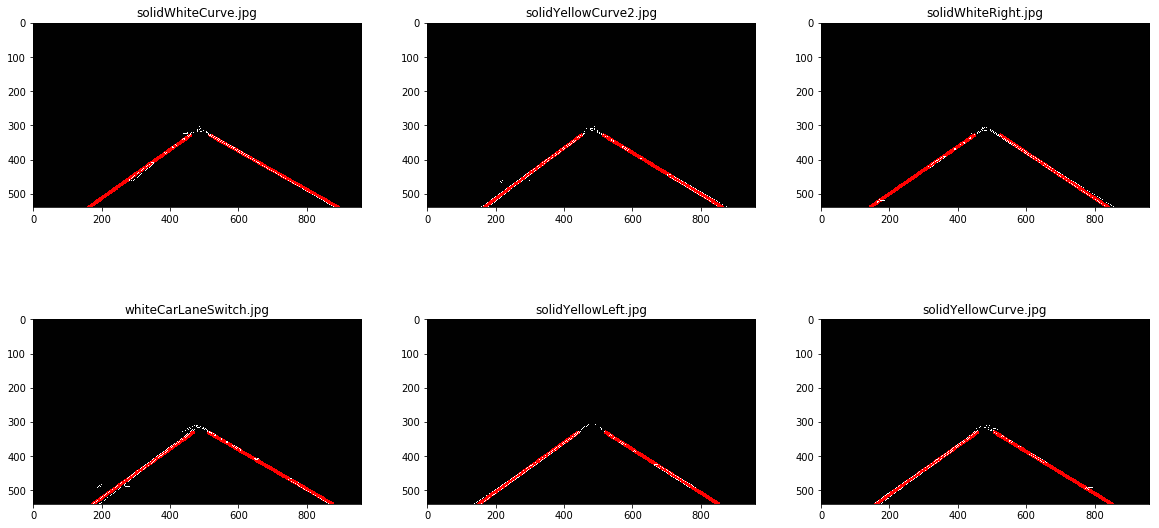

In [6]:
def combine_images(masked_image, line_image):
    # Create a "color" binary image to combine with line image
    if len(masked_image.shape) == 2:
        masked_image = np.dstack((masked_image, masked_image, masked_image))
    
    if len(line_image.shape) == 2:
        line_image = np.dstack((line_image, line_image, line_image))

    # Draw the lines on the edge image
    combo = cv2.addWeighted(masked_image, 1.0, line_image, 1.0, 1)
    # plt.imshow(combo)
    return combo

for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    image_canny = canny_edge(image_gray)
    
    mask_area = make_mask(image)
    image_canny_mask = image_canny * mask_area
    
    line_hough = hough_transform(image, image_canny_mask)
    image_hough_and_line = combine_images(image_canny_mask, line_hough)
    show_image(i, image_hough_and_line)

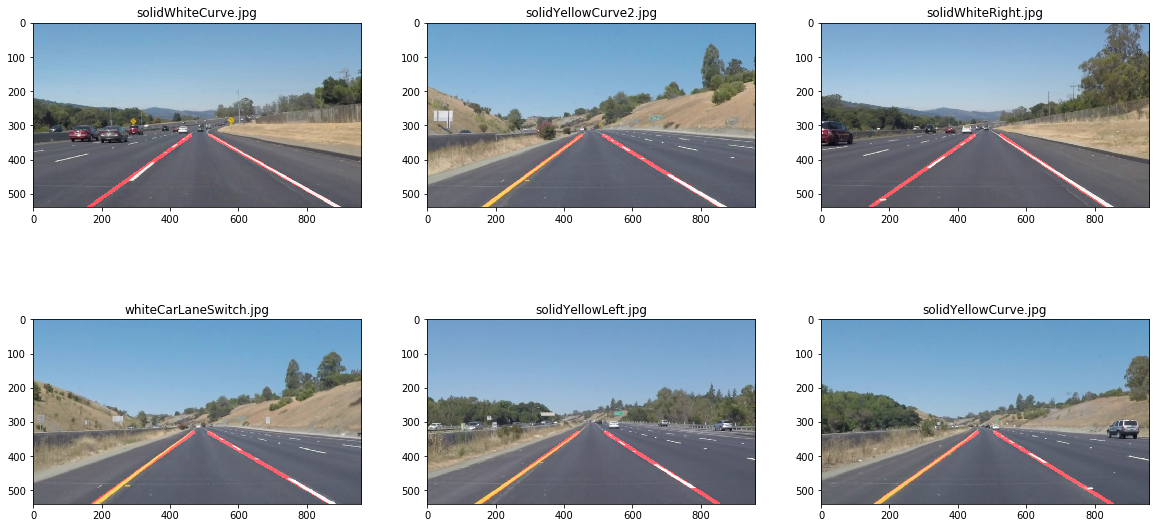

In [7]:
for i in range(len(image_list)):
    image = mpimg.imread(image_dir + image_list[i])
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
    image_canny = canny_edge(image_gray)
    
    mask_area = make_mask(image)
    image_canny_mask = image_canny * mask_area
    
    line_hough = hough_transform(image, image_canny_mask)
    image_line = combine_images(image, line_hough)
    show_image(i, image_line)

In [8]:
import tensorflow as tf

In [9]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# if you met Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so
# $ conda install nomkl

In [10]:
def show_movie(target_file):
    display(HTML("""
    <video width="640" height="360" controls>
      <source src="{0}" type="video/mp4">
    </video>
    """.format(target_file)))

movie_dir = "test_videos/"
movie_list = os.listdir(movie_dir)
for i in movie_list:
    target_file = movie_dir + i
    show_movie(target_file)
    print(i, '\n')

solidWhiteRight.mp4 



solidYellowLeft.mp4 



challenge.mp4 



In [11]:
def lane_detection(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_canny = canny_edge(image_gray)
    image_canny_mask = image_canny * make_mask(image)
    image_line = hough_transform(image, image_canny_mask)
    image_combine = combine_images(image, image_line)
    return image_combine

In [12]:
def process_image(image):
    try:
        return lane_detection(image)    
    except Exception as e:
        print(e)
        return image

In [13]:
for i in movie_list:
    white_output = 'test_videos_output/' + i
    clip1 = VideoFileClip("test_videos/" + i).subclip(0,5)
    white_clip = clip1.fl_image(lambda x: process_image(x)) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


 99%|█████████▉| 125/126 [00:06<00:00, 20.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.06 s, sys: 972 ms, total: 7.03 s
Wall time: 7.33 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


 99%|█████████▉| 125/126 [00:06<00:00, 19.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.02 s, sys: 1.01 s, total: 7.03 s
Wall time: 7.34 s
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


 79%|███████▉  | 100/126 [00:09<00:02, 10.66it/s]

none


 82%|████████▏ | 103/126 [00:09<00:02, 10.63it/s]

none


 85%|████████▍ | 107/126 [00:10<00:01, 10.65it/s]

none


 98%|█████████▊| 124/126 [00:11<00:00, 10.56it/s]

none


 99%|█████████▉| 125/126 [00:11<00:00, 10.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10.2 s, sys: 2.11 s, total: 12.3 s
Wall time: 15 s


In [14]:
dirplace = "test_videos_output/"
movie_list = os.listdir(dirplace)
for i in movie_list:
    target_file = dirplace + i
    show_movie(target_file)
    print(i, '\n')

solidWhiteRight.mp4 



solidYellowLeft.mp4 



challenge.mp4 

